<a href="https://colab.research.google.com/github/Lexie-v2/Goggle-CO/blob/main/Redes_Neuronales_Artificiales_Vera_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción a Keras: Implementando una RNA para clasificar imagenes

IMPLEMENTACIÒN DE UNA RED NEURONAL ARTIFICIAL

##0. Importaciòn de librerias

Como primer paso, vamos a importar las librerias especificas necesarias pra la implementaciòn de la Red Neuronal Artificial, en este caso usaremos el framework **Keras**

Procedemos con la instalaciòn de Keras mediante el paquete de **keras-core**

In [ ]:
#!pip install keras-core

Con la nueva version de Keras, podemos escoger que backend vamos a utilizar, debemos tener en cuenta que por defecto se selecciona **tensorflow**, sin embargo, tenemos disponibles otros backends como **pytorch** o **jax**.
No olvidar que el backend debe configurarse antes de importar Keras y no puede cambiarse despues de la importaciòn.

In [ ]:
#import os
#os.environ["KERAS_BACKEND"] = "torch"

Importamos Keras con el backend seleccionado

In [ ]:
# import keras_core

Otra opcion es utilizar Keras desde el framework Tensorflow. Si el backend que vamos a utilizar es Tensorflow, esta opcion està màs optimizada y suele proporcionar mejores resultados.

Tanto Keras-core como la versión de Keras que se encuentra en framework Tensorflow son totalmente compatibles y no requieren modificaciones en la implementación del programa..

In [1]:
from tensorflow import keras
#Verificamos si el backend (Tensorflow) està utilizando la GPU
import tensorflow as tf
tf.test.gpu_device_name()

''

##1. Preparacion del conjunto de datos de entrenamiento

Descargamos el conjunto de datos de imagenes. En este caso practico vamos a ahacer uso de conjunto de datos "Dogs vs Cats" de Kaggle.

El conjunto de datos contiene 25000 imagenes de perros y gatos. El objetivo es entrenar una RNA profunda utilizando estos rchivos para que sea capaz de clasificar nuevas imagenes en funciòn de si aparece un perro y un gato.

In [2]:
# Descargamos el conjunto de datos en el almacenamiento temporal de Google Colab
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
# Descomprimimos el conjunto de datos
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  82.4M      0  0:00:09  0:00:09 --:--:--  102M


Montamos

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# Guardamos el conjunto de datos en el almacenamiento persistente de Google Drive
!unzip -d /content/drive/MyDrive/data_IA kagglecatsanddogs_5340.zip

##1.2. Limpieza de datos

Cuando trabajamos con un conjunto de daos reales, suele pasar que algunos de los ejemplos esten corruptos o incompletos y haya que eliminarlos.

En este caso, debemos recorrr el conjunto de datos buscando imagenes que no se encuentren en el formato adecuado.

In [3]:
#Ruta de conjunto de datos
DATASET_PATH = "/content/PetImages"

import tensorflow as tf
import os

def filter_images():
  deleted_imgs = 0
  for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(DATASET_PATH, folder_name)
    for image in os.listdir (folder_path):
      img_path = os.path.join(folder_path, image)
      try:
        fobj = open(img_path, "rb")
        # Comprobamos si la imagen esta en formato JPEG
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        deleted_imgs += 1
        # Eliminamos la imagen correspondiente
        os.remove(img_path)
        print(f"Imágenes eliminadas: {deleted_imgs}")

filter_images()

Imágenes eliminadas: 1
Imágenes eliminadas: 2
Imágenes eliminadas: 3
Imágenes eliminadas: 4
Imágenes eliminadas: 5
Imágenes eliminadas: 6
Imágenes eliminadas: 7
Imágenes eliminadas: 8
Imágenes eliminadas: 9
Imágenes eliminadas: 10
Imágenes eliminadas: 11
Imágenes eliminadas: 12
Imágenes eliminadas: 13
Imágenes eliminadas: 14
Imágenes eliminadas: 15
Imágenes eliminadas: 16
Imágenes eliminadas: 17
Imágenes eliminadas: 18
Imágenes eliminadas: 19
Imágenes eliminadas: 20
Imágenes eliminadas: 21
Imágenes eliminadas: 22
Imágenes eliminadas: 23
Imágenes eliminadas: 24
Imágenes eliminadas: 25
Imágenes eliminadas: 26
Imágenes eliminadas: 27
Imágenes eliminadas: 28
Imágenes eliminadas: 29
Imágenes eliminadas: 30
Imágenes eliminadas: 31
Imágenes eliminadas: 32
Imágenes eliminadas: 33
Imágenes eliminadas: 34
Imágenes eliminadas: 35
Imágenes eliminadas: 36
Imágenes eliminadas: 37
Imágenes eliminadas: 38
Imágenes eliminadas: 39
Imágenes eliminadas: 40
Imágenes eliminadas: 41
Imágenes eliminadas: 42
I

##1.3. Creación de un Dataset con Keras

Otro de los aspectos importantes cuando utilizamos un conjunto de datos de imágenes es normalizar su tamaño. Lo habitual cuando trabajamos con imágenes reales es que tengan diferentes tamaños.

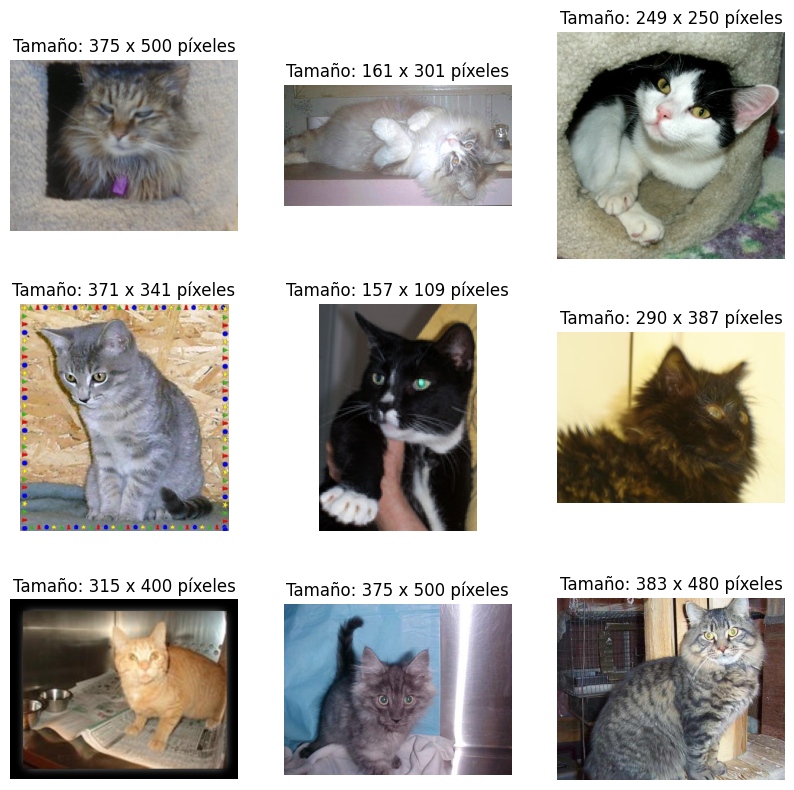

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plt.figure(figsize=(10, 10))
folder_path = os.path.join(DATASET_PATH, "Cat")
for i, image in enumerate(os.listdir(folder_path)[:9]):
    img_path = os.path.join(folder_path, image)
    img = mpimg.imread(img_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} píxeles")
    plt.axis("off")

plt.show()

Keras nos permite normalizar el tamaño de las imágenes de nuestro conjunto de datos haciendo uso de funciones auxiliares que convierten
los datos a un objeto Dataset de los diferentes backends que estemos utilizando.

Tensorflow: https://www.tensorflow.org/api.docs/python/tf/data/Dataset

In [5]:
image_size = (180, 180)
batch_size = 128 # Tamaño de lote

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2, # 20% de los datos forman parte del subconjunto de validación
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


Podemos observar que las imágenes tienen el mismo tamaño.

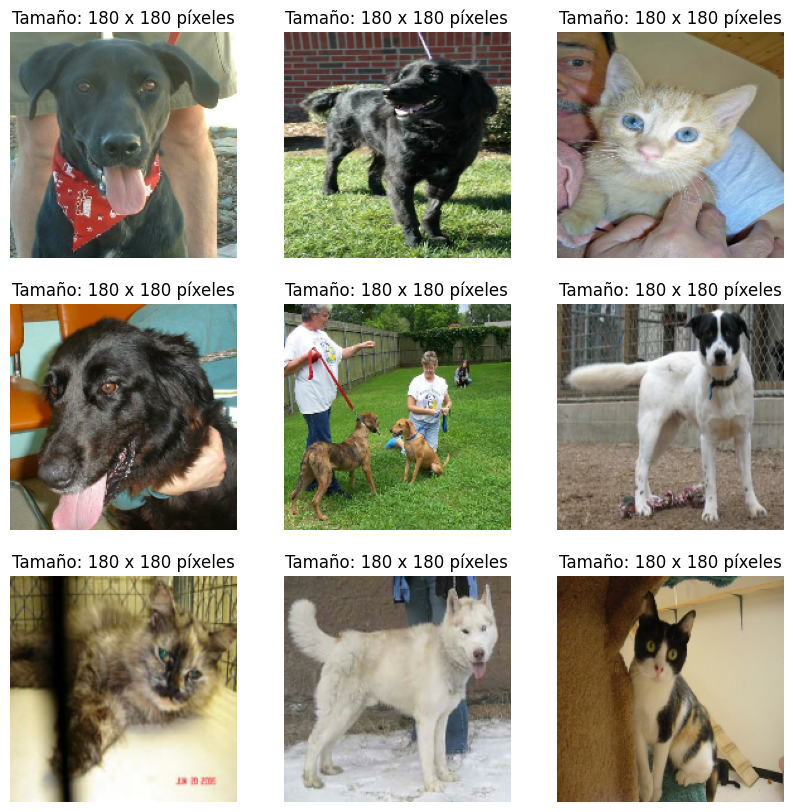

In [6]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1): # take(1) obtiene un lote del conjunto de datos (128 ejemplos)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Tamaño: {images[i].shape[0]} x {images[i].shape[1]} píxeles")
        plt.axis("off")

plt.show()

## 1.4. Separación de la etiqueta (label)

Por norma general, las redes neuronales artificiales profundas suelen corresponderse con técnicas de Machine Learning basadas en aprendizaje supervisado.

Esto quiere decir, que durante el proceso de entrenamiento o aprendizaje van a requerir un conjunto de datos etiquetado.

Un conjunto de datos etiquetado se caracteriza porque está formado por los elementos de entrada (en este caso las imágenes) y los elementos de salida o etiqueta (en este caso el valor 0 si aparece un gato en la imagen y 1 si aparece un perro).

El objetivo de la RNA es aprender lo suficiente del conjunto de datos de entrenamiento para poder recibir imágenes que no se encuentran en el conjunto de datos y predecir de manera autónoma la etiqueta.

La función de Keras que hemos utilizado anteriormente ha etiquetado las imágenes en función de la carpeta en la que se encontraban.

Número de imágenes en el batch: 128
Etiquetas del batch: [0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1
 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0
 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0]


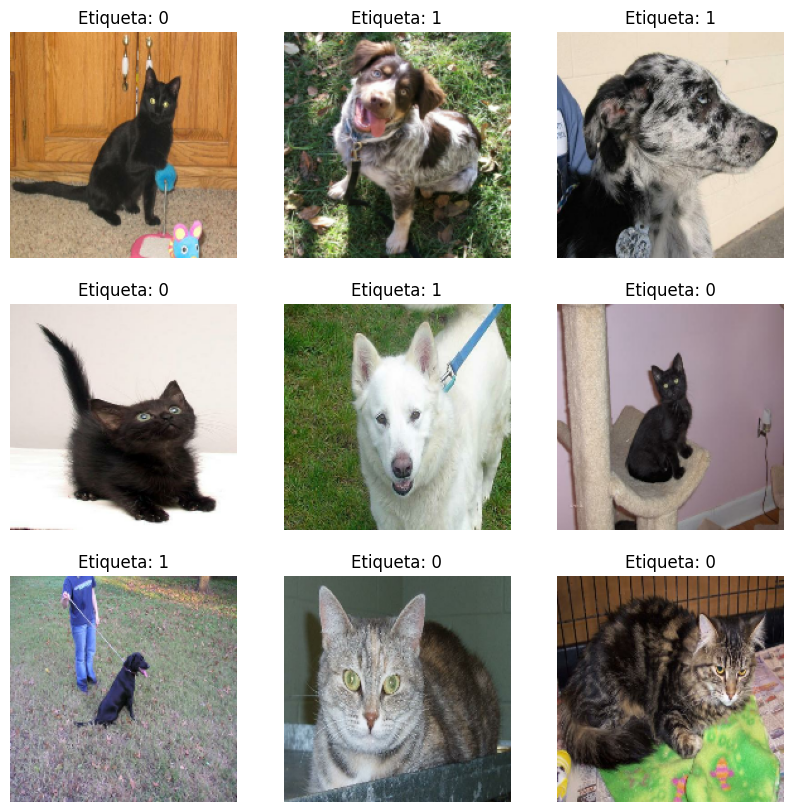

In [7]:
# El conjunto de datos de entrenamiento está formado por 147 batches
len(train_ds)

# Cada batch está formado por 128 imágenes y sus correspondientes etiquetas
batch1 = list(train_ds.take(1))
batch1

print(f"Número de imágenes en el batch: {len(batch1[0][0])}")
print(f"Etiquetas del batch: {batch1[0][1]}")

# Mostramos dos imágenes del batch con su etiqueta
plt.figure(figsize=(10, 10))

for img, etiqueta in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(f"Etiqueta: {etiqueta[i]}")
        plt.axis("off")

plt.show()
